# DATA ANALYSIS REPORT
Tha gas and 
The aim of this study is to predict the gas usage with time and characteristics of weather e.g., temperature. In the prediction model, we would care more about which feature has more predictive value on gas usage.
In order to do that, a random forest was included for the modelling. Random forest is an ensemble method which can capter both linear and non-linear relationship between predictors and response variables. 

In [5]:
import sqlalchemy as sa
import pandas as pd
import seaborn as sns

# get the data from table p1g
engine = sa.create_engine("sqlite:///myhome.db")
sql = sa.text("SELECT * FROM p1g")
p1g_df = pd.read_sql(sql, con=engine)
p1g_df.dropna(axis=0, inplace=True)
print(p1g_df.head())

# get the data from table openweather
sql = sa.text("SELECT * FROM openweathermap")
openwheatermap_df = pd.read_sql(sql, con=engine)
openwheatermap_df.dropna(axis=0, inplace=True)
print(openwheatermap_df.head())
print(openwheatermap_df.columns)

# merge the two table
openwheatermap_gas = p1g_df.merge(openwheatermap_df, how="inner", on = "unixtime")
print(openwheatermap_gas.columns)



openwheatermap_gas['month'] = pd.to_datetime(openwheatermap_gas['time']).dt.month
openwheatermap_gas['year'] = pd.to_datetime(openwheatermap_gas['time']).dt.year
openwheatermap_gas.head()

                  time  Total gas used    unixtime
7353  2022-03-18 14:15        3422.015  1647612900
7354  2022-03-18 14:30        3422.028  1647613800
7355  2022-03-18 14:45        3422.033  1647614700
7356  2022-03-18 15:00        3422.065  1647615600
7357  2022-03-18 15:15        3422.089  1647616500
                         date  temperature_2m_°C  relativehumidity_2m_%  \
0  2022-01-01 00:00:00.000000               10.2              95.740547   
1  2022-01-01 01:00:00.000000               10.2              95.419624   
2  2022-01-01 02:00:00.000000               10.1              94.458282   
3  2022-01-01 03:00:00.000000               10.0              94.454018   
4  2022-01-01 04:00:00.000000               10.1              94.776604   

   rain_mm  snowfall_cm  windspeed_10m_km/h  winddirection_10m_°  \
0      0.0          0.0           21.028437           231.952911   
1      0.0          0.0           20.466246           230.710617   
2      0.0          0.0           22.32

,time,Total gas used,unixtime,date,temperature_2m_°C,relativehumidity_2m_%,rain_mm,snowfall_cm,windspeed_10m_km/h,winddirection_10m_°,soil_temperature_0_to_7cm_°C,month,year
0,2022-03-18 15:00,3422.065,1647615600,2022-03-18 15:00:00.000000,14.10,56.581459,0.0,0.0,17.076300,55.304783,13.25,3,2022
1,2022-03-18 15:00,3422.065,1647615600,2022-03-18 15:00:00.000000,14.10,56.581459,0.0,0.0,17.076300,55.304783,13.25,3,2022
2,2022-03-18 16:00,3422.123,1647619200,2022-03-18 16:00:00.000000,13.20,59.370182,0.0,0.0,15.876775,57.030594,12.70,3,2022
3,2022-03-18 16:00,3422.123,1647619200,2022-03-18 16:00:00.000000,13.20,59.370182,0.0,0.0,15.876775,57.030594,12.70,3,2022
4,2022-03-18 17:00,3422.200,1647622800,2022-03-18 17:00:00.000000,12.05,66.272362,0.0,0.0,13.849477,62.102829,11.90,3,2022


d:\Programs\Anacoda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


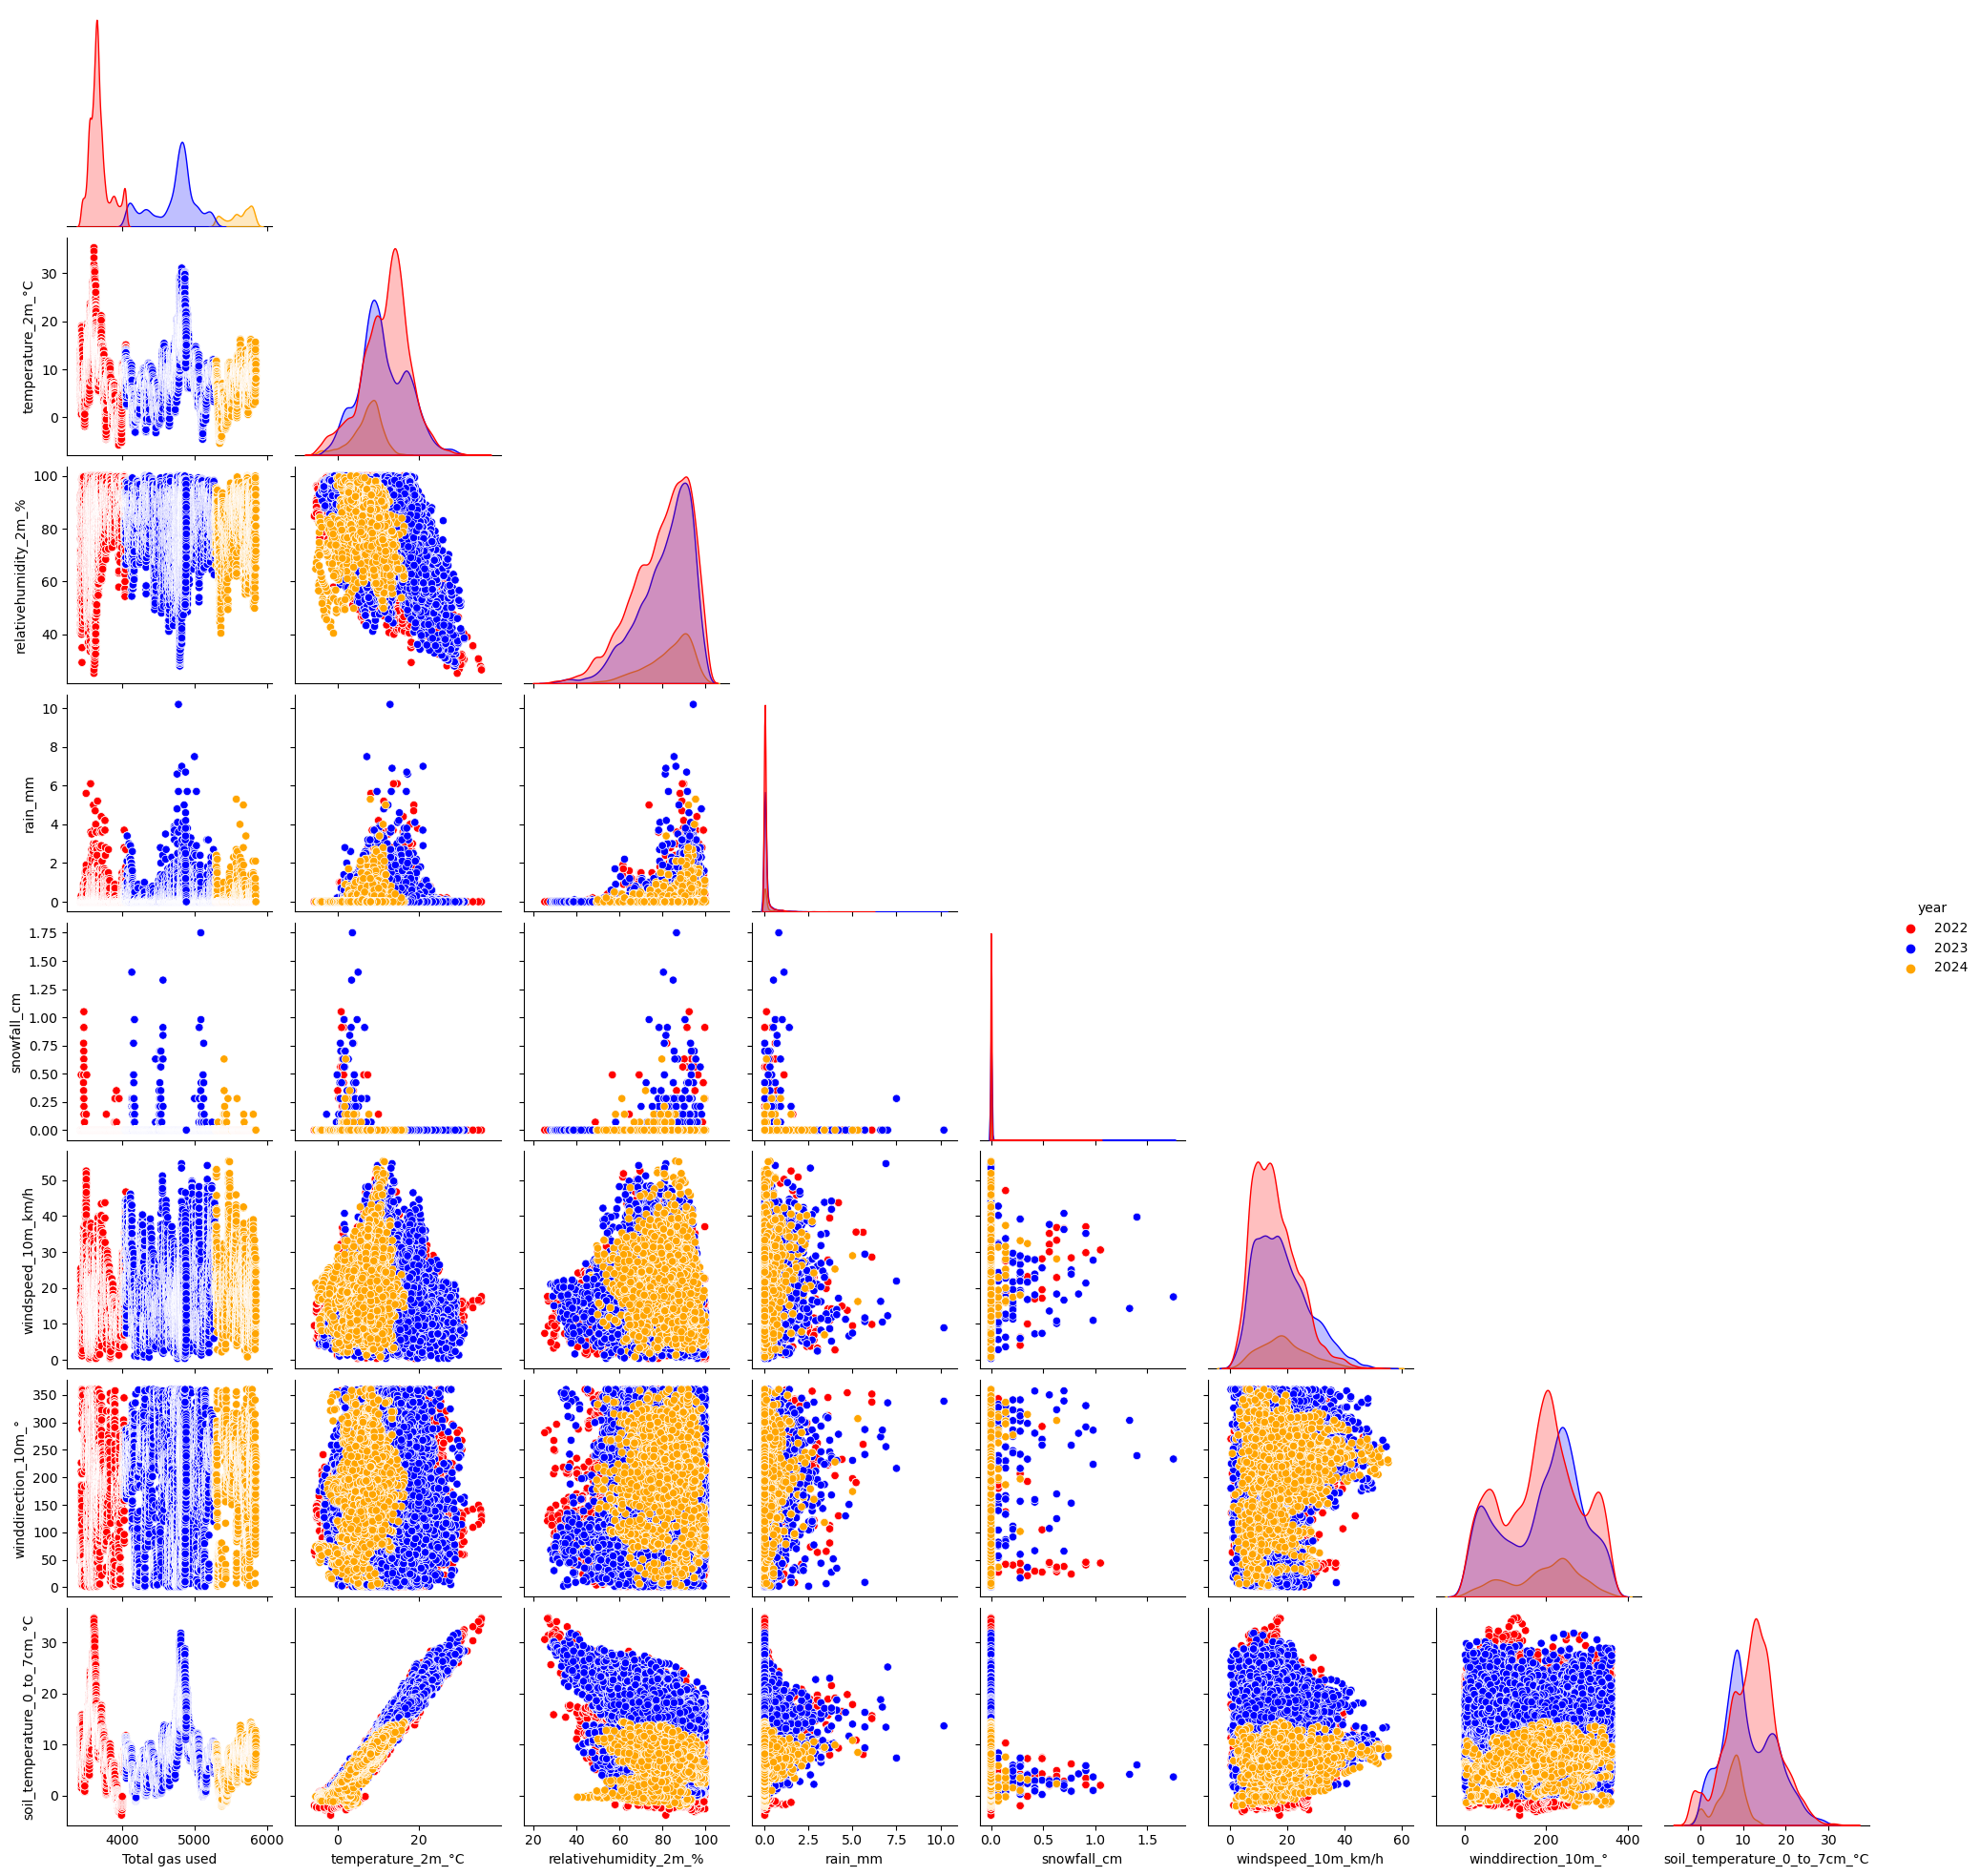

In [6]:
palette =  sns.color_palette("hls", 8)
sns.pairplot(openwheatermap_gas.drop(columns=["time", "date", "unixtime", "month"]), hue="year", corner=True, palette={2022: "red", 2023:"blue", 2024:"orange"})

In [7]:
from sklearn.model_selection import train_test_split
data = openwheatermap_gas.drop(columns=["time", "date", "unixtime"])
X = data.drop(columns=["Total gas used"])
y = data["Total gas used"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# cross validation on the training set
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100, 200, 300],
              'min_impurity_decrease': [8, 10, 12],
              'max_features': [3, 4, 5, 6, 7],
              'max_depth': [70, 80, 90]
              }

rf_model = RandomForestRegressor(n_estimators = 50, random_state= 40)
clf = GridSearchCV(rf_model, param_grid=parameters, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_estimators=50, random_state=40),
             n_jobs=-1,
             param_grid={'max_depth': [70, 80, 90],
                         'max_features': [3, 4, 5, 6, 7],
                         'min_impurity_decrease': [8, 10, 12],
                         'n_estimators': [100, 200, 300]})

In [8]:
clf.best_estimator_

RandomForestRegressor(max_depth=70, max_features=5, min_impurity_decrease=8,
                      n_estimators=300, random_state=40)

<Axes: ylabel='Total gas used'>

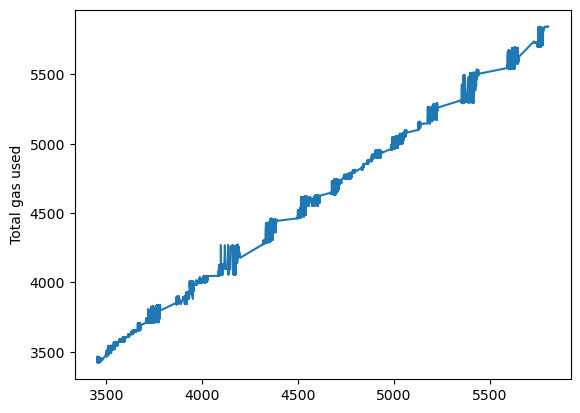

In [9]:
# use the parameters selected to refit the model on the whole traing set
rf_model = RandomForestRegressor(max_depth=70, max_features=5, min_impurity_decrease=8, n_estimators=300, random_state=40)
rf_model.fit(X_train, y_train)

# see model performance on test set
predictions = rf_model.predict(X_test)
sns.lineplot(x=predictions, y = y_test)

In [10]:
# generate the feature importance of the model
importances = rf_model.feature_importances_
columns = X.columns
i = 0

while i < len(columns):
    print(f"The importance of feature {columns[i]} is {round(importances[i] * 100, 2)}%")
    i = i + 1

The importance of feature temperature_2m_°C is 0.68%
The importance of feature relativehumidity_2m_% is 0.14%
The importance of feature rain_mm is 0.01%
The importance of feature snowfall_cm is 0.0%
The importance of feature windspeed_10m_km/h is 0.3%
The importance of feature winddirection_10m_° is 0.48%
The importance of feature soil_temperature_0_to_7cm_°C is 1.53%
The importance of feature month is 11.26%
The importance of feature year is 85.6%


According to the output we can see that variable 'year' has the most predictive value for gas usage. We assume that is due to the underlying gas price in those years.